In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [36]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [3]:
data = pd.read_csv('get_around_pricing_project.csv')

In [4]:
data

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,4838,Toyota,39743,110,diesel,black,van,False,True,False,False,False,False,True,121
4839,4839,Toyota,49832,100,diesel,grey,van,False,True,False,False,False,False,True,132
4840,4840,Toyota,19633,110,diesel,grey,van,False,True,False,False,False,False,True,130
4841,4841,Toyota,27920,110,diesel,brown,van,True,True,False,False,False,False,True,151


In [5]:
data = data.iloc[:, 1:]
data

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,Toyota,39743,110,diesel,black,van,False,True,False,False,False,False,True,121
4839,Toyota,49832,100,diesel,grey,van,False,True,False,False,False,False,True,132
4840,Toyota,19633,110,diesel,grey,van,False,True,False,False,False,False,True,130
4841,Toyota,27920,110,diesel,brown,van,True,True,False,False,False,False,True,151


In [ ]:
X = data.drop(columns=['rental_price_per_day'])
y = data['rental_price_per_day']


numerical_features = ['mileage', 'engine_power']
categorical_features = [col for col in X.columns if col not in numerical_features]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'LGBMRegressor': lgb.LGBMRegressor(random_state=42),
    'CatBoostRegressor': CatBoostRegressor(verbose=0, random_state=42),
    'SVR': SVR(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'ElasticNet': ElasticNet()
}


cv = KFold(n_splits=5, shuffle=True, random_state=42)


for model_name, model in models.items():
    train_mse, test_mse = [], []
    train_mae, test_mae = [], []
    train_r2, test_r2 = [], []
    
    print(f"\n{model_name} Cross-Validation Results:")
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        pipeline.fit(X_train, y_train)
        
        
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        
        train_mse.append(mean_squared_error(y_train, y_pred_train))
        train_mae.append(mean_absolute_error(y_train, y_pred_train))
        train_r2.append(r2_score(y_train, y_pred_train))
        
        
        test_mse.append(mean_squared_error(y_test, y_pred_test))
        test_mae.append(mean_absolute_error(y_test, y_pred_test))
        test_r2.append(r2_score(y_test, y_pred_test))
    
    
    print(f"Train MSE: {np.mean(train_mse):.3f} ± {np.std(train_mse):.3f}")
    print(f"Test MSE: {np.mean(test_mse):.3f} ± {np.std(test_mse):.3f}")
    print(f"Train MAE: {np.mean(train_mae):.3f} ± {np.std(train_mae):.3f}")
    print(f"Test MAE: {np.mean(test_mae):.3f} ± {np.std(test_mae):.3f}")
    print(f"Train R2: {np.mean(train_r2):.3f} ± {np.std(train_r2):.3f}")
    print(f"Test R2: {np.mean(test_r2):.3f} ± {np.std(test_r2):.3f}")



LinearRegression Cross-Validation Results:
Train MSE: 323.117 ± 15.416
Test MSE: 341.103 ± 59.220
Train MAE: 12.085 ± 0.120
Test MAE: 12.330 ± 0.496
Train R2: 0.713 ± 0.010
Test R2: 0.699 ± 0.033

RandomForestRegressor Cross-Validation Results:
Train MSE: 38.900 ± 1.577
Test MSE: 279.724 ± 49.481
Train MAE: 3.915 ± 0.054
Test MAE: 10.611 ± 0.270
Train R2: 0.965 ± 0.001
Test R2: 0.753 ± 0.031

GradientBoostingRegressor Cross-Validation Results:
Train MSE: 246.982 ± 14.768
Test MSE: 296.959 ± 66.385
Train MAE: 10.370 ± 0.138
Test MAE: 11.278 ± 0.505
Train R2: 0.781 ± 0.010
Test R2: 0.738 ± 0.042

XGBRegressor Cross-Validation Results:
Train MSE: 63.824 ± 3.795
Test MSE: 275.199 ± 49.263
Train MAE: 5.443 ± 0.154
Test MAE: 10.479 ± 0.293
Train R2: 0.943 ± 0.003
Test R2: 0.757 ± 0.029

LGBMRegressor Cross-Validation Results:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And i

In [ ]:
catboost_param_grid = {
    'model__iterations': [500, 1000, 1500],
    'model__depth': [6, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__l2_leaf_reg': [1, 3, 5, 7],
    'model__bagging_temperature': [0.0, 0.5, 1.0]
}

lgbm_param_grid = {
    'model__n_estimators': [200, 500, 1000],
    'model__max_depth': [6, 8, 10, -1],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [20, 31, 50],
    'model__feature_fraction': [0.7, 0.8, 1.0],
    'model__bagging_fraction': [0.7, 0.8, 1.0]
}


models = {
    'CatBoostRegressor': (Pipeline(steps=[('preprocessor', preprocessor), ('model', CatBoostRegressor(verbose=0, random_state=42))]), catboost_param_grid),
    'LGBMRegressor': (Pipeline(steps=[('preprocessor', preprocessor), ('model', lgb.LGBMRegressor(random_state=42))]), lgbm_param_grid)
}


cv = KFold(n_splits=5, shuffle=True, random_state=42)


best_models = {}
for model_name, (pipeline, param_grid) in models.items():
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=20,
        cv=cv,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )
    search.fit(X, y)
    
    best_models[model_name] = search.best_estimator_
    print(f"\nBest parameters for {model_name}: {search.best_params_}")
    
   
    train_mse, test_mse = [], []
    train_mae, test_mae = [], []
    train_r2, test_r2 = [], []
    
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        
        model = best_models[model_name]
        model.fit(X_train, y_train)
        
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        
        train_mse.append(mean_squared_error(y_train, y_pred_train))
        train_mae.append(mean_absolute_error(y_train, y_pred_train))
        train_r2.append(r2_score(y_train, y_pred_train))
        
        
        test_mse.append(mean_squared_error(y_test, y_pred_test))
        test_mae.append(mean_absolute_error(y_test, y_pred_test))
        test_r2.append(r2_score(y_test, y_pred_test))
    
    
    print(f"\n{model_name} Train Metrics:")
    print(f"Train MSE: {np.mean(train_mse):.3f} ± {np.std(train_mse):.3f}")
    print(f"Train MAE: {np.mean(train_mae):.3f} ± {np.std(train_mae):.3f}")
    print(f"Train R2: {np.mean(train_r2):.3f} ± {np.std(train_r2):.3f}")
    
    print(f"\n{model_name} Test Metrics:")
    print(f"Test MSE: {np.mean(test_mse):.3f} ± {np.std(test_mse):.3f}")
    print(f"Test MAE: {np.mean(test_mae):.3f} ± {np.std(test_mae):.3f}")
    print(f"Test R2: {np.mean(test_r2):.3f} ± {np.std(test_r2):.3f}")

/home/jules/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jules/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jules/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jules/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/jules/anaconda3/lib/python3.12/site-packages/sk


Best parameters for CatBoostRegressor: {'model__learning_rate': 0.05, 'model__l2_leaf_reg': 1, 'model__iterations': 1500, 'model__depth': 6, 'model__bagging_temperature': 0.0}

CatBoostRegressor Train Metrics:
Train MSE: 77.094 ± 2.796
Train MAE: 6.167 ± 0.104
Train R2: 0.932 ± 0.003

CatBoostRegressor Test Metrics:
Test MSE: 249.061 ± 47.876
Test MAE: 10.019 ± 0.330
Test R2: 0.780 ± 0.031
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008659 seconds.
You can set `force_r

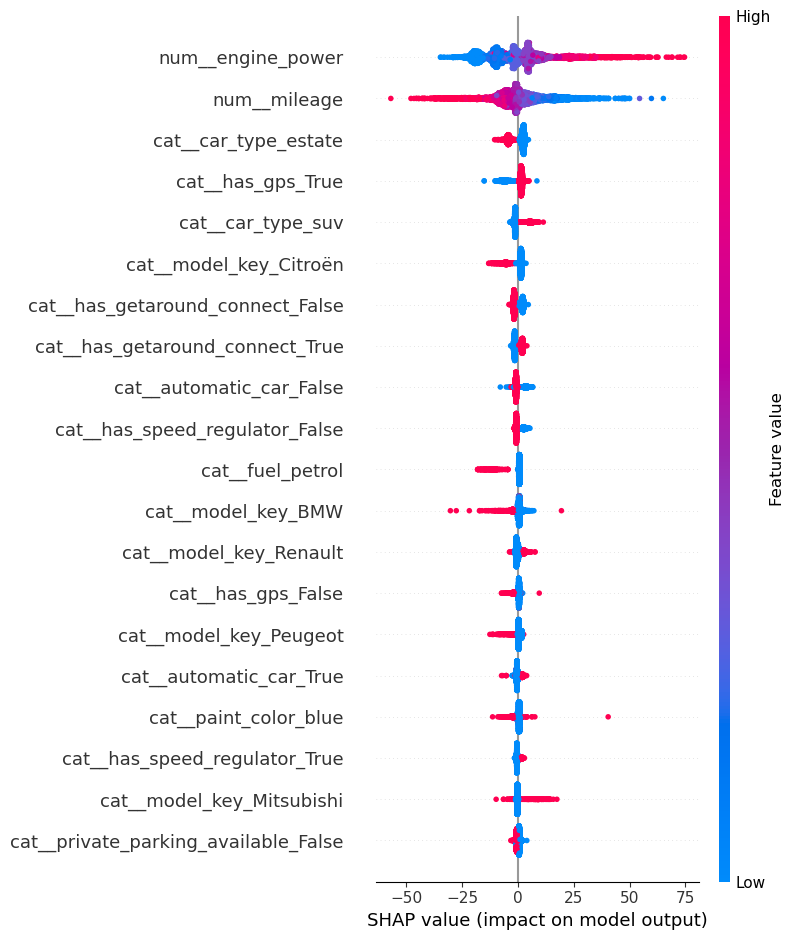

In [ ]:
import shap
from sklearn.preprocessing import OneHotEncoder


preprocessor = best_models['CatBoostRegressor'].named_steps['preprocessor']
model = best_models['CatBoostRegressor'].named_steps['model']


X_transformed = preprocessor.transform(X)
if hasattr(X_transformed, "toarray"):  
    X_transformed = X_transformed.toarray()


X_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed)


shap.summary_plot(shap_values, X_transformed)

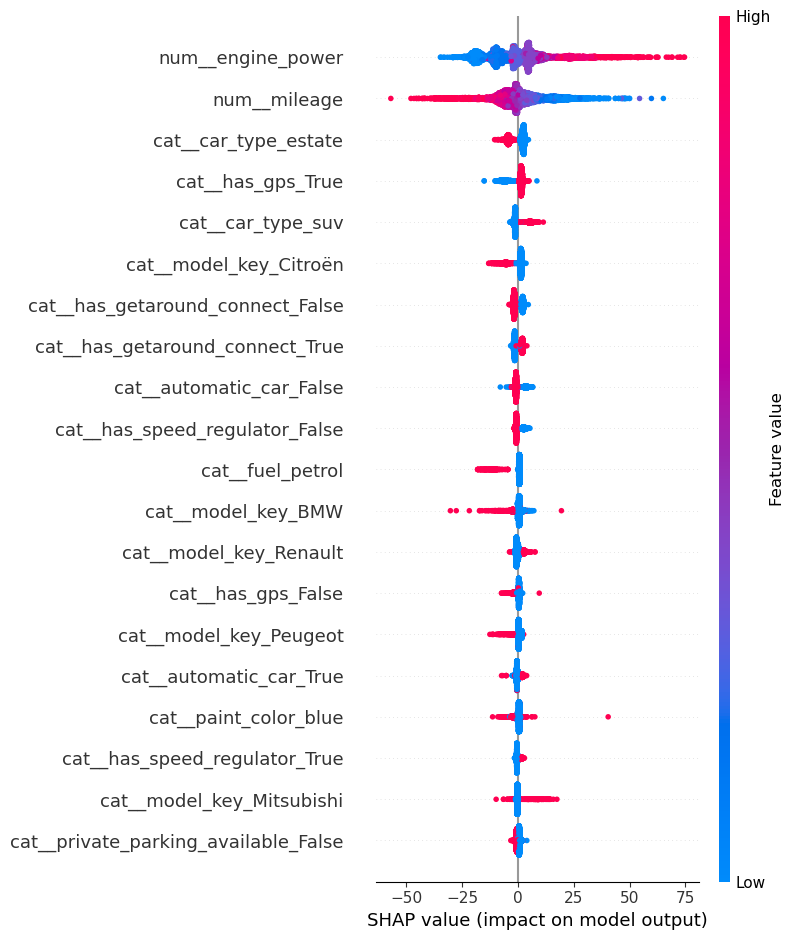

In [ ]:
preprocessor = best_models['CatBoostRegressor'].named_steps['preprocessor']
model = best_models['CatBoostRegressor'].named_steps['model']


X_transformed = preprocessor.transform(X)
if hasattr(X_transformed, "toarray"):  
    X_transformed = X_transformed.toarray()


X_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed)
shap.summary_plot(shap_values, X_transformed)

In [48]:
data['car_fuel_combination'] = data['car_type'] + "_" + data['fuel']
data = data.drop(columns=['paint_color'])
data = data.drop(columns=['car_type','fuel'])

In [ ]:

X = data.drop(columns=['rental_price_per_day'])
y = data['rental_price_per_day']


numerical_features = ['mileage', 'engine_power']
categorical_features = [col for col in X.columns if col not in numerical_features]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


catboost_param_grid = {
    'model__iterations': [1000],
    'model__depth': [2,4,6],
    'model__learning_rate': [0.05],
    'model__l2_leaf_reg': [3,10,15],
    'model__bagging_temperature': [0.5]
}


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(verbose=0, random_state=42))
])


cv = KFold(n_splits=5, shuffle=True, random_state=42)


search = RandomizedSearchCV(
    pipeline,
    param_distributions=catboost_param_grid,
    n_iter=20,  
    cv=cv,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)


best_model = search.best_estimator_
print(f"\nBest parameters for CatBoostRegressor: {search.best_params_}")


train_mse, test_mse = [], []
train_mae, test_mae = [], []
train_r2, test_r2 = [], []

for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    best_model.fit(X_train, y_train)
    
    
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    
    train_mse.append(mean_squared_error(y_train, y_pred_train))
    train_mae.append(mean_absolute_error(y_train, y_pred_train))
    train_r2.append(r2_score(y_train, y_pred_train))
    
    
    test_mse.append(mean_squared_error(y_test, y_pred_test))
    test_mae.append(mean_absolute_error(y_test, y_pred_test))
    test_r2.append(r2_score(y_test, y_pred_test))


print("\nCatBoostRegressor Train Metrics:")
print(f"Train MSE: {pd.Series(train_mse).mean():.3f} ± {pd.Series(train_mse).std():.3f}")
print(f"Train MAE: {pd.Series(train_mae).mean():.3f} ± {pd.Series(train_mae).std():.3f}")
print(f"Train R2: {pd.Series(train_r2).mean():.3f} ± {pd.Series(train_r2).std():.3f}")

print("\nCatBoostRegressor Test Metrics:")
print(f"Test MSE: {pd.Series(test_mse).mean():.3f} ± {pd.Series(test_mse).std():.3f}")
print(f"Test MAE: {pd.Series(test_mae).mean():.3f} ± {pd.Series(test_mae).std():.3f}")
print(f"Test R2: {pd.Series(test_r2).mean():.3f} ± {pd.Series(test_r2).std():.3f}")

/home/jules/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best parameters for CatBoostRegressor: {'model__learning_rate': 0.05, 'model__l2_leaf_reg': 3, 'model__iterations': 1000, 'model__depth': 6, 'model__bagging_temperature': 0.5}

CatBoostRegressor Train Metrics:
Train MSE: 140.220 ± 6.411
Train MAE: 8.097 ± 0.169
Train R2: 0.876 ± 0.005

CatBoostRegressor Test Metrics:
Test MSE: 257.930 ± 57.999
Test MAE: 10.297 ± 0.353
Test R2: 0.772 ± 0.038
